# Telecom Customer Churn

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import skew, kurtosis
from imblearn.over_sampling import SMOTE

import mlflow
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from statsmodels.api import Logit
import pickle

from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings

warnings.filterwarnings("ignore")
start_time = datetime.now()

In [2]:
ROOT_PATH = Path(__name__).resolve().parent.parent

FILE_NAME = "TelecomCustomerChurn.csv"

FILE_PATH = os.path.join(ROOT_PATH, "data",FILE_NAME)

In [3]:
df = pd.read_csv(FILE_PATH)
df.head()

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Monthly,Yes,Manual,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Manual,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.isnull().sum()

customerID          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df["TotalCharges"] = df["TotalCharges"].apply(
    lambda x: None if x == " " else float(x)
)

In [7]:
df.isnull().sum()

customerID           0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
amount_of_nulls = df["TotalCharges"].isna().sum()
amount_of_data = len(df)

print(f"{(amount_of_nulls / amount_of_data) * 100} %")

0.1561834445548772 %


Since this amount of NaN values represents only 0.15% of the data, we can take it out because it won't make a big impact on our analysis

In [9]:
df = df.loc[~df["TotalCharges"].isna()]

In [10]:
df

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Monthly,Yes,Manual,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Manual,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Manual,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,74.40,306.60,Yes


#### Evaluating the Gender acitivity

In [11]:
df_gender_churn = df.groupby(
    ["Gender", "Churn"]
    ).agg({"Churn":"count"}).rename(
        columns={"Churn": "churn_count"}
    ).reset_index()

df_gender_churn = df_gender_churn.pivot_table(
    index="Gender", values="churn_count", columns="Churn"
)

df_gender_churn

Churn,No,Yes
Gender,,
Female,2544.0,939.0
Male,2619.0,930.0


Just evalue if there is a statistical relevance on Male and Female churns

Applying a Statistical teste called: Chi-Squared 

In [12]:
def statistical_chisquared(p_value: float):
    if p_value <= 0.05:
        print(f"There is a relevant difference between these genres. \np_value: {p_value}")
    else:
        print(f"There is no relevant difference between these genres. \np_value: {p_value}")

In [13]:
chi2, p, dof, expected = chi2_contingency(df_gender_churn)
statistical_chisquared(p)

There is no relevant difference between these genres. 
p_value: 0.490488470706551


In [14]:
df["Gender"].value_counts()

Gender
Male      3549
Female    3483
Name: count, dtype: int64

In [15]:
df.groupby(
    ["Gender"]
    ).agg({"TotalCharges":"sum"}).rename(
        columns={"TotalCharges": "TotalCharges_sum"}
    ).reset_index()

,Gender,TotalCharges_sum
0,Female,7952354.2
1,Male,8103814.5


#### Evaluating type of service

In [16]:
df["InternetService"].value_counts()

InternetService
Fiber optic    3096
DSL            2416
No             1520
Name: count, dtype: int64

In [17]:
df_internet_service = df.groupby(
    ["InternetService", "Churn"]
    ).agg({"Churn":"count"}).rename(
        columns={"Churn": "churn_count"}
    ).reset_index()

df_internet_service = df_internet_service.pivot_table(
    index="InternetService", values="churn_count", columns="Churn"
)

df_internet_service["total"] = df_internet_service["No"] + df_internet_service["Yes"]

df_internet_service["churn_percent_service_categ"] = (df_internet_service["Yes"] / df_internet_service["total"]) * 100
df_internet_service["churn_percent_global"] = (df_internet_service["total"] / df_internet_service["total"].sum()) * 100

df_internet_service

Churn,No,Yes,total,churn_percent_service_categ,churn_percent_global
InternetService,,,,,
DSL,1957.0,459.0,2416.0,18.998344,34.357224
Fiber optic,1799.0,1297.0,3096.0,41.892765,44.027304
No,1407.0,113.0,1520.0,7.434211,21.615472


The Fiber Optic Internet represents 44% of the customer. However it is clear that the amount of customer in Fiber Optic 41% are cancelling our sevices. Proportionally it makes sense because the are the biggest amount of customers, although our services are not supplying the customer expecations of more than 40% of our client databases.

Based on bussiness areas needs I could proceed with the some more Ad Hoc Analysis. Although I'll move forward to the modeling structure

In [18]:
df

,customerID,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Monthly,Yes,Manual,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Manual,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Manual,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No,DSL,Yes,...,No,No,No,No,Monthly,Yes,Manual,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Monthly,Yes,Manual,74.40,306.60,Yes


In [19]:
df_dummy = pd.get_dummies(data=df.drop(["customerID", "Churn"], axis=1), dtype=int)
df_dummy.head()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Gender_Female,Gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_No,StreamingMovies_Yes,Contract_Monthly,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Manual
0,0,1,29.85,29.85,1,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,1
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,1,0,0,1,0,1,0,0,0,1
2,0,2,53.85,108.15,0,1,1,0,1,0,...,1,0,1,0,0,0,1,0,0,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,1,0,0,1,0,1,0,1,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,1,0,1,0,0,0,1,0,0,1


In [20]:
df_dummy.describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,Gender_Female,Gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_No,StreamingMovies_Yes,Contract_Monthly,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Manual
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.495307,0.504693,0.517491,0.482509,0.701507,0.298493,...,0.611633,0.388367,0.551052,0.209329,0.239619,0.407281,0.592719,0.219283,0.216297,0.564420
std,0.368844,24.545260,30.085974,2266.771362,0.500014,0.500014,0.499729,0.499729,0.457629,0.457629,...,0.487414,0.487414,0.497422,0.406858,0.426881,0.491363,0.491363,0.413790,0.411748,0.495868
min,0.000000,1.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


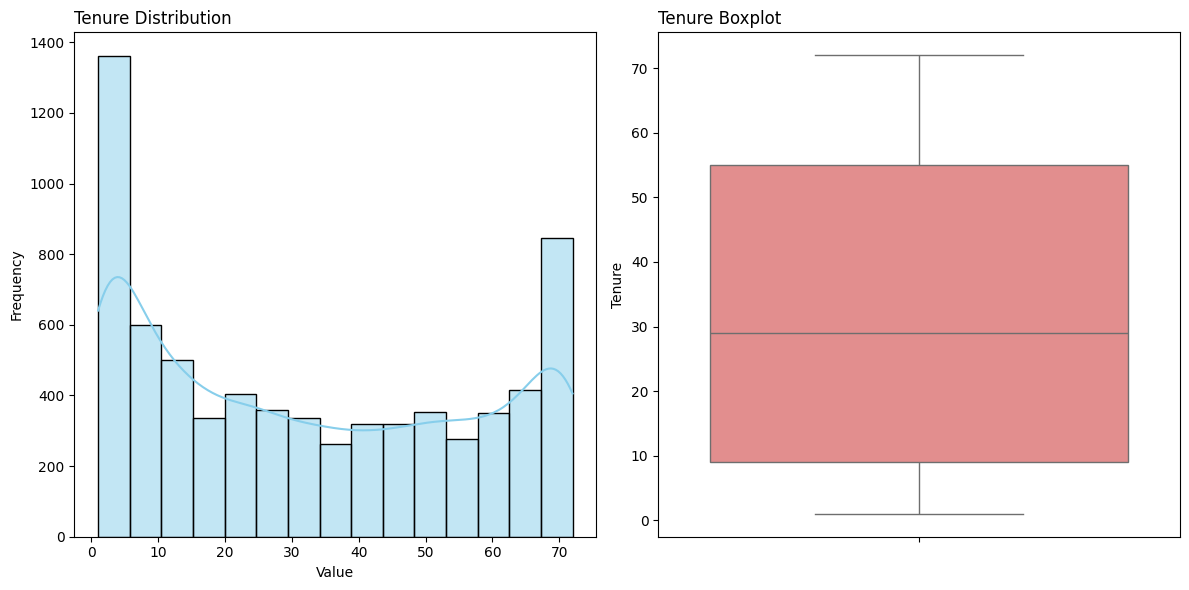

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df_dummy, x="Tenure", kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Tenure Distribution", loc="left")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

sns.boxplot(data=df_dummy, y="Tenure", ax=axes[1], color="lightcoral")
axes[1].set_title("Tenure Boxplot", loc="left")

plt.tight_layout()
plt.show();

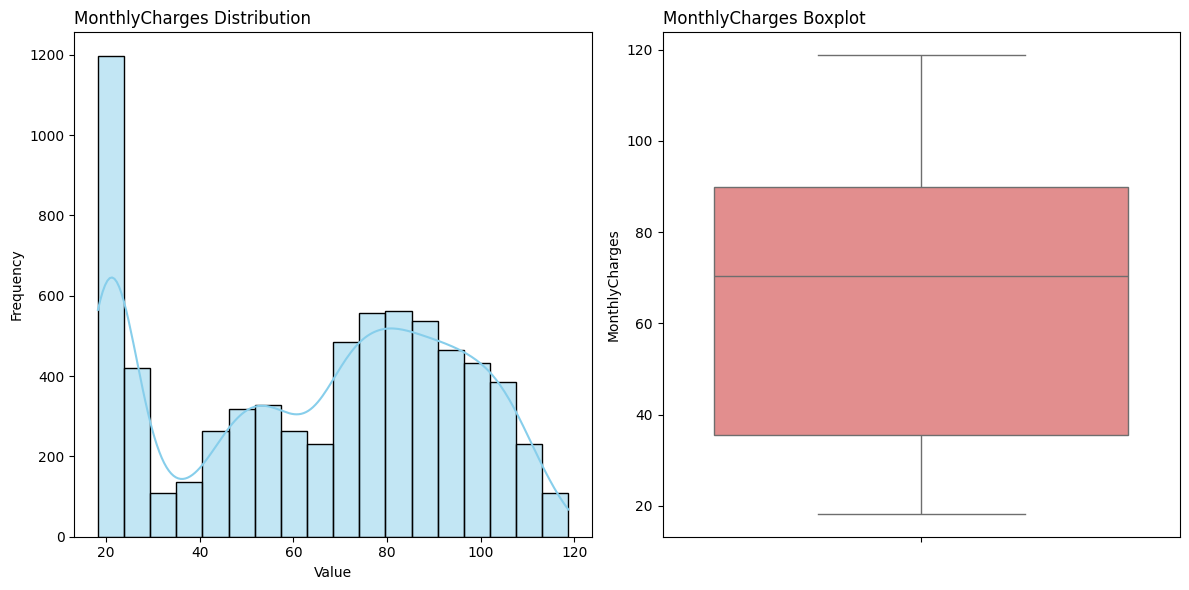

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df_dummy, x="MonthlyCharges", kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("MonthlyCharges Distribution", loc="left")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

sns.boxplot(data=df_dummy, y="MonthlyCharges", ax=axes[1], color="lightcoral")
axes[1].set_title("MonthlyCharges Boxplot", loc="left")

plt.tight_layout()
plt.show();

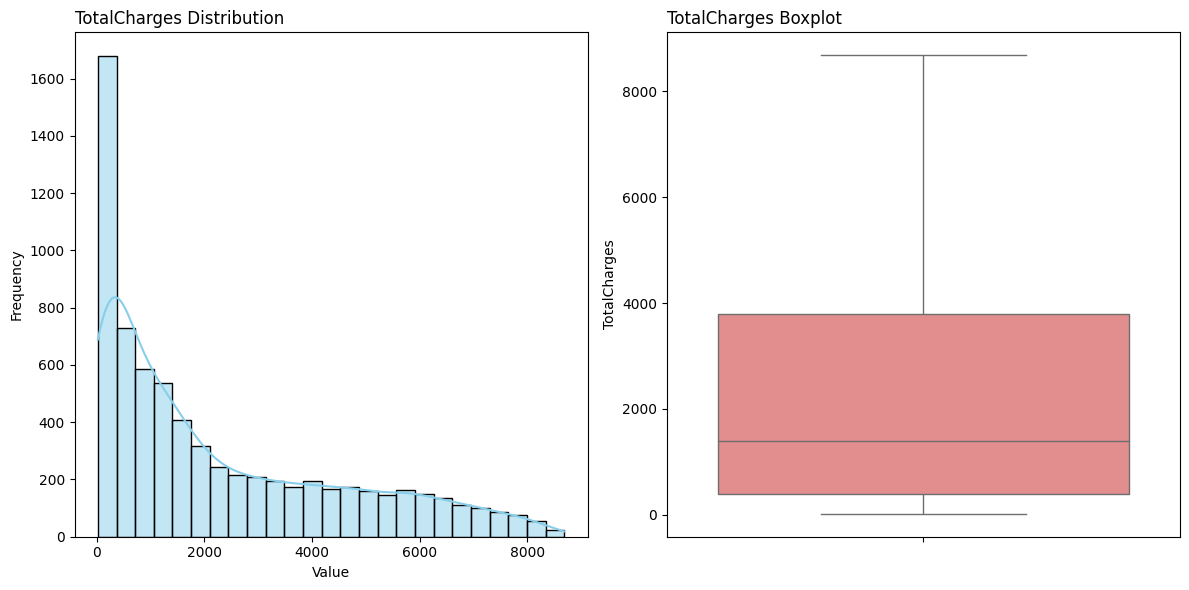

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=df_dummy, x="TotalCharges", kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("TotalCharges Distribution", loc="left")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")

sns.boxplot(data=df_dummy, y="TotalCharges", ax=axes[1], color="lightcoral")
axes[1].set_title("TotalCharges Boxplot", loc="left")

plt.tight_layout()
plt.show();

In [24]:
df_dummy_temp = pd.get_dummies(data=df.drop(["customerID", "Churn"], axis=1), dtype=int, drop_first=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = df_dummy_temp.columns
vif_data["VIF"] = [variance_inflation_factor(df_dummy_temp.values, i) for i in range(df_dummy_temp.shape[1])]

vif_data

,Feature,VIF
0,SeniorCitizen,1.372809
1,Tenure,19.961285
2,MonthlyCharges,211.407548
3,TotalCharges,20.975890
4,Gender_Male,2.021273
5,Partner_Yes,2.822596
6,Dependents_Yes,1.967383
7,PhoneService_Yes,47.183952
8,MultipleLines_Yes,2.843424
9,InternetService_Fiber optic,17.342421


Variables with high level of multicolinearity. I'll try dropping some variables with high values to evaluate if the VIF reduces

In [25]:
test_cols_drop = ["customerID", "Churn", "MonthlyCharges", "Tenure"]
df_dummy_temp = pd.get_dummies(data=df.drop(test_cols_drop, axis=1), dtype=int, drop_first=True)

vif_data = pd.DataFrame()
vif_data["Feature"] = df_dummy_temp.columns
vif_data["VIF"] = [variance_inflation_factor(df_dummy_temp.values, i) for i in range(df_dummy_temp.shape[1])]

vif_data

,Feature,VIF
0,SeniorCitizen,1.352379
1,TotalCharges,7.948890
2,Gender_Male,1.923930
3,Partner_Yes,2.747944
4,Dependents_Yes,1.959154
5,PhoneService_Yes,9.229601
6,MultipleLines_Yes,2.504991
7,InternetService_Fiber optic,3.858821
8,InternetService_No,3.173177
9,OnlineSecurity_Yes,1.980164


There was a good reduction of VIF on the remaining variables. Let's proceed with these to the model

Checking data Balancing

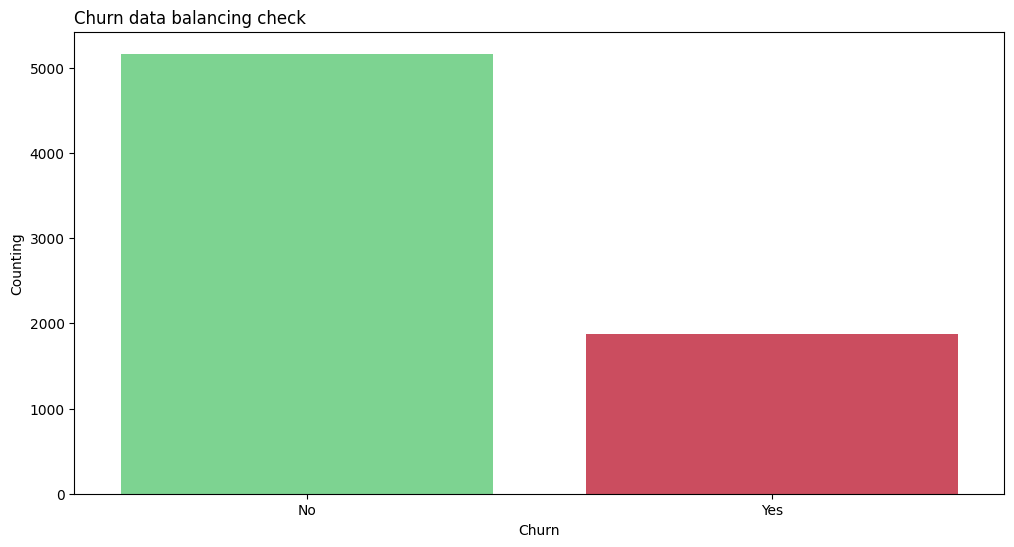

In [26]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="Churn", hue="Churn", palette={"Yes": "#E03850", "No": "#6FE189"})
plt.title("Churn data balancing check", loc="left")
plt.ylabel("Counting")
plt.show();

In [27]:
balance_analysis = pd.DataFrame(
    [df["Churn"].value_counts().to_dict()]
).T.rename(columns={0: "count"})

balance_analysis["percent"] = (balance_analysis["count"] / balance_analysis["count"].sum()) * 100
balance_analysis

,count,percent
No,5163,73.421502
Yes,1869,26.578498


In [28]:
df["Churn"] = df["Churn"].apply(
    lambda x: 1 if x=="Yes" else 0
)

In [29]:
sampler = SMOTE()
data_smote = sampler.fit_resample(df_dummy, df["Churn"])

X_smote = data_smote[0]
y_smote = data_smote[1]

Separate data into X, y, Train and Test

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2)

print("Independent DF for Training:", X_train.shape)
print("Independent DF for Testing:", X_test.shape)
print("\nDependent DF for Training:", y_train.shape)
print("Dependent DF for Testing:", y_test.shape)

Independent DF for Training: (8260, 37)
Independent DF for Testing: (2066, 37)

Dependent DF for Training: (8260,)
Dependent DF for Testing: (2066,)


In [31]:
def compute_statistics(series: pd.Series):
    data = np.array(series).astype(float)
    
    stats = {
        "mean": np.mean(data),
        "median": np.median(data),
        "std": np.std(data, ddof=1),
        "skewness": skew(data, bias=False),
        "kurtosis": kurtosis(data, bias=False)
    }

    return stats

In [32]:
def get_variable_dist(df: pd.DataFrame):
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("Data Drift Monitor")

    for col in df.columns:
        with mlflow.start_run(run_name=f"drift_{datetime.today()}"):
            ## Creating IMAGE
            img_path = f"../data/image/{col}.png"

            _, axes = plt.subplots(1, 2, figsize=(12, 6))
            sns.histplot(data=df, x=f"{col}", kde=True, ax=axes[0], color="skyblue")
            axes[0].set_title(f"{col} Distribution", loc="left")
            axes[0].set_xlabel("Value")
            axes[0].set_ylabel("Frequency")

            sns.boxplot(data=df, y=f"{col}", ax=axes[1], color="lightcoral")
            axes[1].set_title(f"{col} Boxplot", loc="left")

            plt.savefig(img_path)
            plt.close()

            ## Creating Statistics
            stats = compute_statistics(df[col])

            mlflow.set_tag(key="table_column", value=col)
            mlflow.log_artifact(img_path, artifact_path=f"plots")
            mlflow.log_metric(key="mean", value=stats["mean"])
            mlflow.log_metric(key="median", value=stats["median"])
            mlflow.log_metric(key="std", value=stats["std"])
            mlflow.log_metric(key="skewness", value=stats["skewness"])
            mlflow.log_metric(key="kurtosis", value=stats["kurtosis"])

In [33]:
get_variable_dist(df_dummy)

2025/10/22 19:17:51 INFO mlflow.tracking.fluent: Experiment with name 'Data Drift Monitor' does not exist. Creating a new experiment.


🏃 View run drift_2025-10-22 19:17:51.434421 at: http://localhost:5000/#/experiments/437167362689241952/runs/b27c69b3f1fd410496691b976054762d
🧪 View experiment at: http://localhost:5000/#/experiments/437167362689241952
🏃 View run drift_2025-10-22 19:17:51.882464 at: http://localhost:5000/#/experiments/437167362689241952/runs/837cef0d744b41d09104b1d20e86944b
🧪 View experiment at: http://localhost:5000/#/experiments/437167362689241952
🏃 View run drift_2025-10-22 19:17:52.186947 at: http://localhost:5000/#/experiments/437167362689241952/runs/be20e28ccadb48d08f9b438068ee9172
🧪 View experiment at: http://localhost:5000/#/experiments/437167362689241952
🏃 View run drift_2025-10-22 19:17:52.503279 at: http://localhost:5000/#/experiments/437167362689241952/runs/2e02f7f84c67456bbc6feaaa75ee6362
🧪 View experiment at: http://localhost:5000/#/experiments/437167362689241952
🏃 View run drift_2025-10-22 19:17:52.827173 at: http://localhost:5000/#/experiments/437167362689241952/runs/bfd22b42496a42af84bd

## Model

Measuring model performance:<br>

But, which metrics should I use?<br>

Erro Tipo I (α) — Falso Positivo
Ocorre quando o modelo detecta algo que não existe.

Em termos estatísticos: rejeita a hipótese nula quando ela é verdadeira.

Na matriz: corresponde ao FP (False Positive).

In [34]:
def quantify_model_prediction(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    return precision, conf_matrix

In [ ]:
def save_model_on_blob(model, model_name):
    blob_path = "../models/"

    # model_name = type(model).__name__

    deep_learning_models = ["Sequential"]
    if model_name in deep_learning_models:
        model_file = f"{model_name}_{datetime.today().strftime("%Y%m%d_%H%M%S")}.keras"
        model_path = os.path.join(blob_path, model_file)

        model.save(model_path)
        print("Deep Learning model saved successfully.")
    else:
        model_file = f"{model_name}_{datetime.today().strftime("%Y%m%d_%H%M%S")}.pkl"
        model_path = os.path.join(blob_path, model_file)

        with open(model_path, "wb") as f:
            pickle.dump(obj=model, file=f)
        print("Machine Learning model saved successfully.")

    return model_path

In [ ]:
def register_model_experiment(model_name: str, y_true, y_pred, type: str, model_path=""):

    recall, conf_matrix = quantify_model_prediction(y_true, y_pred)

    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("Churn Model Experiment")

    with mlflow.start_run(run_name=f"{model_name}_{datetime.today()}"):
        mlflow.log_metric(key="precision", value=recall)
        mlflow.set_tag(key="Type", value=type)
        try:
            mlflow.log_artifact(local_path=model_path, artifact_path="model")
        except:
            pass

### Modeling

In [37]:
base_model = Logit(y_train, X_train) # Using the standard parameters
base_model = base_model.fit()

base_model_response = base_model.predict(X_train)

Optimization terminated successfully.
         Current function value: 0.315052
         Iterations 10


In [38]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 8260
Model:                          Logit   Df Residuals:                     8223
Method:                           MLE   Df Model:                           36
Date:                Wed, 22 Oct 2025   Pseudo R-squ.:                  0.5455
Time:                        19:18:04   Log-Likelihood:                -2602.3
converged:                       True   LL-Null:                       -5725.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
SeniorCitizen                               0.0907      0.095      0.957      0.339      -0.095       0.276
Tenure                                     -0.0679      0.006    -10.520      0.000      -0.081      -0.055
MonthlyCharges                              0.3443      0.020     17.206      0.000       0.305       0.384
TotalCharges                                0.0004    7.3e-05      5.863      0.000       0.000       0.001
Gender_Female                              -2.3075      0.414     -5.580      0.000      -3.118      -1.497
Gender_Male                                -2.3466      0.414     -5.675      0.000      -3.157      -1.536
Partner_No                                 -2.0155      0.431     -4.676      0.000      -2.860      -1.171
Partner_Yes                                -2.0371      0.433     -4.700      0.000      -2.887      -1.188
Dependents_No                              -1.6034      0.444     -3.612      0.000      -2.473      -0.733
Dependents_Yes                             -1.9126      0.450     -4.246      0.000      -2.795      -1.030
PhoneService_No                             2.2241      1.139      1.953      0.051      -0.008       4.457
PhoneService_Yes                           -5.4430      1.157     -4.703      0.000      -7.712      -3.175
MultipleLines_No                           -0.5187      0.448     -1.159      0.247      -1.396       0.359
MultipleLines_Yes                          -2.0754      0.463     -4.486      0.000      -2.982      -1.169
InternetService_DSL                        -0.2269      1.203     -0.189      0.850      -2.586       2.132
InternetService_Fiber optic                -7.9027      1.400     -5.646      0.000     -10.646      -5.160
InternetService_No                          7.9284      1.204      6.583      0.000       5.568      10.289
OnlineSecurity_No                           0.0601      0.446      0.135      0.893      -0.814       0.934
OnlineSecurity_Yes                         -2.2060      0.472     -4.675      0.000      -3.131      -1.281
OnlineBackup_No                            -0.5017      0.429     -1.169      0.242      -1.343       0.339
OnlineBackup_Yes                           -2.4926      0.443     -5.625      0.000      -3.361      -1.624
DeviceProtection_No                        -0.2441      0.428     -0.570      0.568      -1.083       0.595
DeviceProtection_Yes                       -2.0403      0.443     -4.602      0.000      -2.909      -1.171
TechSupport_No                              0.1669      0.438      0.381      0.703      -0.691       1.025
TechSupport_Yes                            -2.1249      0.458     -4.639      0.000      -3.023      -1.227
StreamingTV_No                              1.1891      0.471      2.524      0.012       0.266       2.112
StreamingTV_Yes                            -2.0990      0.483     -4.343      0.000      -3.046      -1.152
S

In [39]:
cols_to_drop = [
    "SeniorCitizen",
    "MultipleLines_No",
    "InternetService_DSL",
    "OnlineSecurity_No",
    "OnlineBackup_No",
    "DeviceProtection_No",
    "TechSupport_No",
    "StreamingMovies_No",
    "Contract_Monthly"
]

base_model = Logit(y_train, X_train.drop(cols_to_drop, axis=1)) # Using the standard parameters
base_model = base_model.fit()

base_model_response = base_model.predict(X_train.drop(cols_to_drop, axis=1))

base_model.summary()

Optimization terminated successfully.
         Current function value: 0.315413
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 8260
Model:                          Logit   Df Residuals:                     8232
Method:                           MLE   Df Model:                           27
Date:                Wed, 22 Oct 2025   Pseudo R-squ.:                  0.5450
Time:                        19:18:04   Log-Likelihood:                -2605.3
converged:                       True   LL-Null:                       -5725.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Tenure                                     -0.0675      0.006    -10.547      0.000      -0.080      -0.055
MonthlyCharges                              0.3468      0.020     17.540      0.000       0.308       0.386
TotalCharges                                0.0004   7.26e-05      5.885      0.000       0.000       0.001
Gender_Female                              -2.2967      0.399     -5.753      0.000      -3.079      -1.514
Gender_Male                                -2.3319      0.399     -5.841      0.000      -3.114      -1.549
Partner_No                                 -2.0584      0.426     -4.829      0.000      -2.894      -1.223
Partner_Yes                                -2.0750      0.428     -4.843      0.000      -2.915      -1.235
Dependents_No                              -1.6313      0.440     -3.704      0.000      -2.495      -0.768
Dependents_Yes                             -1.9588      0.447     -4.381      0.000      -2.835      -1.083
PhoneService_No                             1.8294      0.567      3.227      0.001       0.718       2.941
PhoneService_Yes                           -5.8882      0.747     -7.886      0.000      -7.352      -4.425
MultipleLines_Yes                          -1.5749      0.129    -12.193      0.000      -1.828      -1.322
InternetService_Fiber optic                -7.7227      0.501    -15.400      0.000      -8.706      -6.740
InternetService_No                          8.2064      0.516     15.903      0.000       7.195       9.218
OnlineSecurity_Yes                         -2.2857      0.135    -16.897      0.000      -2.551      -2.021
OnlineBackup_Yes                           -2.0087      0.130    -15.484      0.000      -2.263      -1.754
DeviceProtection_Yes                       -1.8122      0.131    -13.876      0.000      -2.068      -1.556
TechSupport_Yes                            -2.3078      0.138    -16.715      0.000      -2.578      -2.037
StreamingTV_No                              1.1351      0.404      2.809      0.005       0.343       1.927
StreamingTV_Yes                            -2.1841      0.432     -5.058      0.000      -3.030      -1.338
StreamingMovies_Yes                        -3.3560      0.217    -15.494      0.000      -3.781      -2.931
Contract_One year                          -0.8217      0.119     -6.924      0.000      -1.054      -0.589
Contract_Two year                          -1.3705      0.188     -7.303      0.000      -1.738      -1.003
PaperlessBilling_No                        -2.5493      0.406     -6.273      0.000      -3.346      -1.753
PaperlessBilling_Yes                       -2.1215      0.405     -5.243      0.000      -2.914      -1.328
PaymentMethod_Bank transfer (automatic)    -2.6803      0.427     -6.282      0.000      -3.517      -1.844
PaymentMethod_Credit card (automatic)      -2.7501      0.428     -6.430      0.000      -3.588      -1.912
P

In [40]:
model_params = {
    "LogisticRegression":{
        "penalty":["l1", "l2", "elasticnet", None],
        "dual": [True, False],
        "tol": [1e-4, 0.001, 0.01],
    }, 
    "RandomForestClassifier":{
        "n_estimators": [10, 100, 1000],
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [10, 100, 1000],
        # "min_samples_split": [1, 2],
        # "min_samples_leaf": [1, 2],
        # "max_features": ["sqrt", "log2", None],
    }, 
    "DecisionTreeClassifier":{
        "splitter": ["best", "random"],
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [10, 100, 1000],
        # "min_samples_split": [1, 2],
        # "min_samples_leaf": [1, 2],
        # "max_features": ["sqrt", "log2", None],
    }, 
    "SVC":{
        "C": [1.0, 2.0, 3.0],
        # "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed"],
        "degree": [3, 6 ,9],
        # "probability": [True, False],
    }, 
    "XGBClassifier":{
        "n_estimators": [1, 5, 15, 30, 60],
        "max_depth": [10, 100, 1000],
        # "max_leaves": [10, 100, 1000],
        # "learning_rate": [1e-4, 0.001, 0.01],
    }, 
}

In [41]:
models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForestClassifier": RandomForestClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "SVC": SVC(),
    "XGBClassifier": XGBClassifier(), 
}

Training with all columns

In [ ]:
for model_name in model_params:
    estimator = models[model_name]
    param_grid = model_params[model_name]

    start_training_time = datetime.now()
    print(f"\n>>>>>>> Training {model_name} <<<<<<")

    grid_cv = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=2
    )

    grid_cv.fit(X_train, y_train)
    model_path = save_model_on_blob(grid_cv, model_name)

    result_prediction_train = grid_cv.predict(X_train)
    register_model_experiment(model_name, y_train, result_prediction_train, "Train")
    
    result_prediction_test = grid_cv.predict(X_test)
    register_model_experiment(model_name, y_test, result_prediction_test, "Test", model_path)
    end_training_time = datetime.now()


    training_time = end_training_time - start_training_time

    print(f">>>>>>> Finishing Training of model {model_name} in {training_time} <<<<<<")



>>>>>>> Training LogisticRegression <<<<<<


2025/10/22 19:18:05 INFO mlflow.tracking.fluent: Experiment with name 'Churn Model Experiment' does not exist. Creating a new experiment.


Machine Learning model saved successfully.
🏃 View run LogisticRegression_2025-10-22 19:18:05.421273 at: http://localhost:5000/#/experiments/876796583348518943/runs/d1391a01453945c8bd72488481fcbb3d
🧪 View experiment at: http://localhost:5000/#/experiments/876796583348518943
🏃 View run LogisticRegression_2025-10-22 19:18:05.553577 at: http://localhost:5000/#/experiments/876796583348518943/runs/661f2d9d3ddb4df0a8f5661c478d9067
🧪 View experiment at: http://localhost:5000/#/experiments/876796583348518943
>>>>>>> Finishing Training of model LogisticRegression in 0:00:01.104547 <<<<<<

>>>>>>> Training RandomForestClassifier <<<<<<
Machine Learning model saved successfully.
🏃 View run RandomForestClassifier_2025-10-22 19:19:28.901993 at: http://localhost:5000/#/experiments/876796583348518943/runs/64cb68dd691c4e868594862e3c35a5eb
🧪 View experiment at: http://localhost:5000/#/experiments/876796583348518943
🏃 View run RandomForestClassifier_2025-10-22 19:19:30.165456 at: http://localhost:5000/#/

Training without columns with p-value >= 0.05

In [43]:
cols_to_drop = [
    "SeniorCitizen",
    "MultipleLines_No",
    "InternetService_DSL",
    "OnlineSecurity_No",
    "OnlineBackup_No",
    "DeviceProtection_No",
    "TechSupport_No",
    "StreamingMovies_No",
    "Contract_Monthly"
]

In [ ]:
for model_name in model_params:
    estimator = models[model_name]
    param_grid = model_params[model_name]

    start_training_time = datetime.now()
    print(f"\n>>>>>>> Training {model_name} <<<<<<")

    grid_cv = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=2
    )

    grid_cv.fit(X_train.drop(cols_to_drop, axis=1), y_train)
    model_path = save_model_on_blob(grid_cv, model_name)

    result_prediction_train = grid_cv.predict(X_train.drop(cols_to_drop, axis=1))
    register_model_experiment(model_name, y_train, result_prediction_train, "Train")
    
    result_prediction_test = grid_cv.predict(X_test.drop(cols_to_drop, axis=1))
    register_model_experiment(model_name, y_test, result_prediction_test, "Test", model_path)
    end_training_time = datetime.now()

    training_time = end_training_time - start_training_time

    print(f">>>>>>> Finishing Training of model {model_name} in {training_time} <<<<<<")


>>>>>>> Training LogisticRegression <<<<<<
Machine Learning model saved successfully.
🏃 View run LogisticRegression_2025-10-22 19:20:02.214517 at: http://localhost:5000/#/experiments/876796583348518943/runs/5f8d3643f367480ebd7baac4ee0f3541
🧪 View experiment at: http://localhost:5000/#/experiments/876796583348518943
🏃 View run LogisticRegression_2025-10-22 19:20:02.325361 at: http://localhost:5000/#/experiments/876796583348518943/runs/086b019c02eb479a9adde5021dff8a5a
🧪 View experiment at: http://localhost:5000/#/experiments/876796583348518943
>>>>>>> Finishing Training of model LogisticRegression in 0:00:00.989602 <<<<<<

>>>>>>> Training RandomForestClassifier <<<<<<
Machine Learning model saved successfully.
🏃 View run RandomForestClassifier_2025-10-22 19:21:17.735983 at: http://localhost:5000/#/experiments/876796583348518943/runs/03dd7cd730b84695b7a568ed601ecd65
🧪 View experiment at: http://localhost:5000/#/experiments/876796583348518943
🏃 View run RandomForestClassifier_2025-10-22 

Reducing the amount of avariables, we've got a small performance improvement during training phase for most of the models. However it does not impact on test that much. Even if it does have such impact, the training was faster. So we can proceed with with this second structure: 'Dropping unecessary columns (Statisticaly non relevant columns)'

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [46]:
model_keras_v1 = keras.Sequential([
    layers.Dense(12, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_keras_v1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history_v1 = model_keras_v1.fit(
    X_train, y_train,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

Epoch 1/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 996us/step - accuracy: 0.6603 - loss: 25.8332 - val_accuracy: 0.7488 - val_loss: 0.5395
Epoch 2/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.7279 - loss: 0.8293 - val_accuracy: 0.6737 - val_loss: 1.5910
Epoch 3/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.7397 - loss: 0.8638 - val_accuracy: 0.7312 - val_loss: 1.2142
Epoch 4/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.7662 - loss: 0.7293 - val_accuracy: 0.7730 - val_loss: 0.4868
Epoch 5/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.7729 - loss: 0.7010 - val_accuracy: 0.7234 - val_loss: 1.3698
Epoch 6/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.7657 - loss: 0.8056 - val_accuracy: 0.7621 - val_loss: 0.9104
Epoch 7/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.7903 - loss: 0.5902 - val_accuracy: 0.8154 - val_loss: 0.3940
Epoch 8/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7892 - loss: 0.

KeyboardInterrupt: 

In [ ]:
result_keras_v1_prob = model_keras_v1.predict(X_test)
result_keras_v1 = (result_keras_v1_prob > 0.5).astype("int32")

model_path = save_model_on_blob(model_keras_v1, type(model_keras_v1).__name__)
quantify_model_prediction(y_test, result_keras_v1)
register_model_experiment("Deep Learning_v1", y_test, result_keras_v1, "Test", model_path)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step
Deep Learning model saved successfully.
🏃 View run Deep Learning_v1_2025-10-22 19:07:36.768116 at: http://localhost:5000/#/experiments/117871352285016720/runs/574a6d655087494fb04e6d4058940738
🧪 View experiment at: http://localhost:5000/#/experiments/117871352285016720


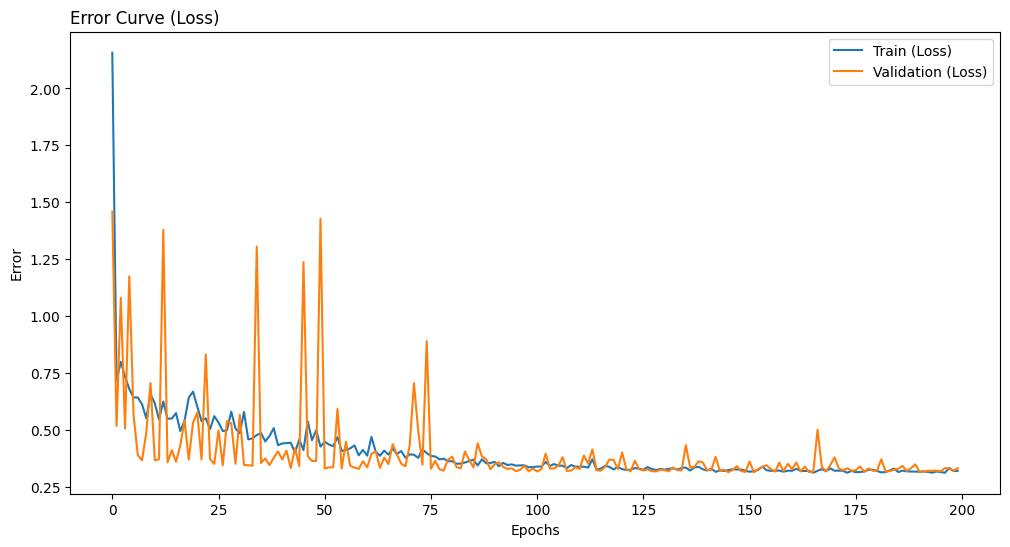

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=history_v1.history, y="loss", x=range(len(history_v1.history["loss"])), label='Train (Loss)')
sns.lineplot(data=history_v1.history, y="val_loss", x=range(len(history_v1.history["val_loss"])), label='Validation (Loss)')
plt.title('Error Curve (Loss)', loc="left")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show();

In [ ]:
model_keras_v2 = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(12, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_keras_v2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history_v2 = model_keras_v2.fit(
    X_train, y_train,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

Epoch 1/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6553 - loss: 6.5627 - val_accuracy: 0.7893 - val_loss: 0.5296
Epoch 2/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - accuracy: 0.7356 - loss: 1.6585 - val_accuracy: 0.6925 - val_loss: 3.3803
Epoch 3/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.7435 - loss: 1.4448 - val_accuracy: 0.8214 - val_loss: 0.4792
Epoch 4/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - accuracy: 0.7467 - loss: 1.9189 - val_accuracy: 0.6949 - val_loss: 4.3030
Epoch 5/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.7730 - loss: 1.1708 - val_accuracy: 0.6955 - val_loss: 1.5016
Epoch 6/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.7707 - loss: 1.2593 - val_accuracy: 0.7996 - val_loss: 0.8290
Epoch 7/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - accuracy: 0.7701 - loss: 1.1671 - val_accuracy: 0.8269 - val_loss: 0.4448
Epoch 8/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.7688 - loss: 1.1

In [ ]:
result_keras_v2_prob = model_keras_v2.predict(X_test)
result_keras_v2 = (result_keras_v2_prob > 0.5).astype("int32")

model_path = save_model_on_blob(model_keras_v2, type(model_keras_v2).__name__)
quantify_model_prediction(y_test, result_keras_v2)
register_model_experiment("Deep Learning_v2", y_test, result_keras_v2, "Test", model_path)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
🏃 View run Deep Learning_v2_2025-10-22 10:34:15.610932 at: http://localhost:5000/#/experiments/117871352285016720/runs/26fa75b54b3643e3987ccdcd24e9d8f3
🧪 View experiment at: http://localhost:5000/#/experiments/117871352285016720


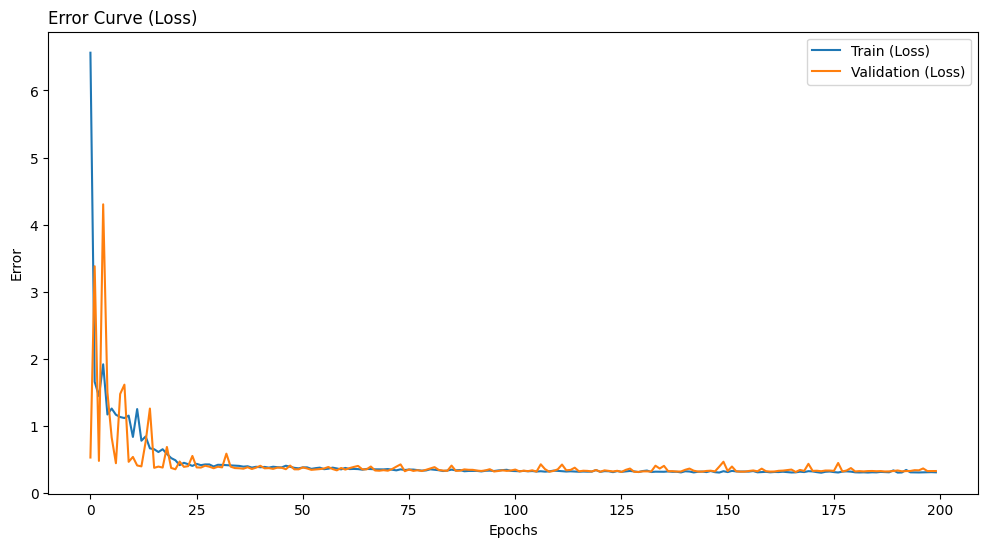

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=history_v2.history, y="loss", x=range(len(history_v2.history["loss"])), label='Train (Loss)')
sns.lineplot(data=history_v2.history, y="val_loss", x=range(len(history_v2.history["val_loss"])), label='Validation (Loss)')
plt.title('Error Curve (Loss)', loc="left")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show();

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [ ]:
model_keras_v3 = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_scaler.shape[1],)),
    layers.Dense(12, activation='relu', input_shape=(X_train_scaler.shape[1],)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_keras_v3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history_v3 = model_keras_v3.fit(
    X_train_scaler, y_train,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

Epoch 1/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7942 - loss: 0.4200 - val_accuracy: 0.8390 - val_loss: 0.3450
Epoch 2/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - accuracy: 0.8488 - loss: 0.3199 - val_accuracy: 0.8462 - val_loss: 0.3309
Epoch 3/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.8609 - loss: 0.3040 - val_accuracy: 0.8481 - val_loss: 0.3324
Epoch 4/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - accuracy: 0.8633 - loss: 0.2972 - val_accuracy: 0.8456 - val_loss: 0.3320
Epoch 5/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - accuracy: 0.8646 - loss: 0.2925 - val_accuracy: 0.8529 - val_loss: 0.3296
Epoch 6/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.8659 - loss: 0.2875 - val_accuracy: 0.8372 - val_loss: 0.3503
Epoch 7/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - accuracy: 0.8668 - loss: 0.2866 - val_accuracy: 0.8462 - val_loss: 0.3327
Epoch 8/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.8676 - loss: 0.2

In [ ]:
result_keras_v3_prob = model_keras_v3.predict(X_test_scaler)
result_keras_v3 = (result_keras_v3_prob > 0.5).astype("int32")

model_path = save_model_on_blob(model_keras_v3, type(model_keras_v3).__name__)
quantify_model_prediction(y_test, result_keras_v3)
register_model_experiment("Deep Learning_v3", y_test, result_keras_v3, "Test", model_path)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
🏃 View run Deep Learning_v3_2025-10-22 10:34:36.639229 at: http://localhost:5000/#/experiments/117871352285016720/runs/f9ec2c4602614f3b8ee2d23f8498f841
🧪 View experiment at: http://localhost:5000/#/experiments/117871352285016720


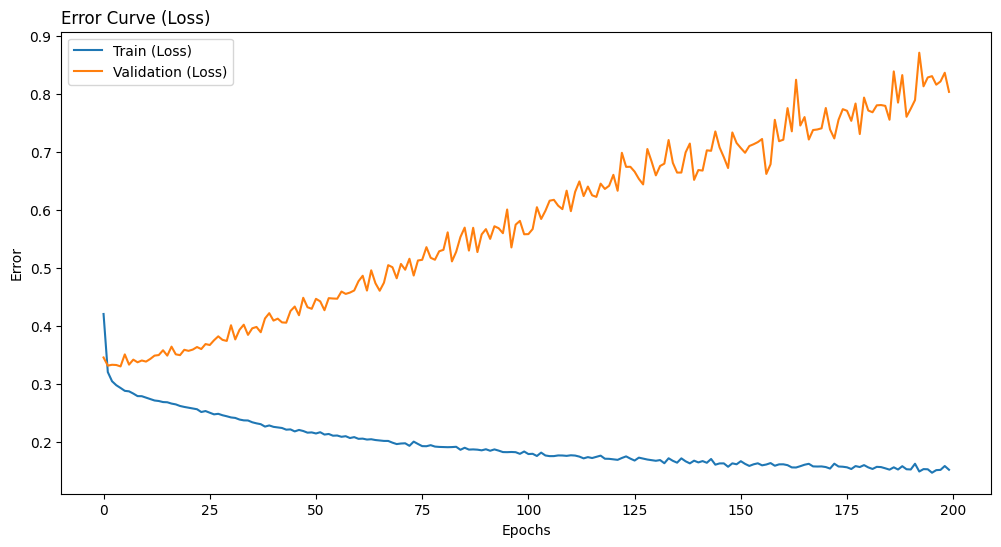

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=history_v3.history, y="loss", x=range(len(history_v3.history["loss"])), label='Train (Loss)')
sns.lineplot(data=history_v3.history, y="val_loss", x=range(len(history_v3.history["val_loss"])), label='Validation (Loss)')
plt.title('Error Curve (Loss)', loc="left")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show();

In [ ]:
model_keras_v4 = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_scaler.shape[1],)),
    layers.Dense(12, activation='relu', input_shape=(X_train_scaler.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_keras_v4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

history_v4 = model_keras_v4.fit(
    X_train_scaler, y_train,
    epochs=200,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

Epoch 1/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7449 - loss: 0.5217 - val_accuracy: 0.8208 - val_loss: 0.3722
Epoch 2/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8140 - loss: 0.4128 - val_accuracy: 0.8360 - val_loss: 0.3458
Epoch 3/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8267 - loss: 0.3894 - val_accuracy: 0.8378 - val_loss: 0.3416
Epoch 4/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8343 - loss: 0.3697 - val_accuracy: 0.8456 - val_loss: 0.3389
Epoch 5/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8273 - loss: 0.3714 - val_accuracy: 0.8408 - val_loss: 0.3396
Epoch 6/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - accuracy: 0.8419 - loss: 0.3567 - val_accuracy: 0.8329 - val_loss: 0.3401
Epoch 7/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8363 - loss: 0.3534 - val_accuracy: 0.8396 - val_loss: 0.3392
Epoch 8/200
826/826 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8354 - loss: 0.3551 - val_a

In [ ]:
result_keras_v4_prob = model_keras_v4.predict(X_test_scaler)
result_keras_v4 = (result_keras_v4_prob > 0.5).astype("int32")

model_path = save_model_on_blob(model_keras_v4, type(model_keras_v4).__name__)
quantify_model_prediction(y_test, result_keras_v4)
register_model_experiment("Deep Learning_v4", y_test, result_keras_v4, "Test", model_path)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step
🏃 View run Deep Learning_v4_2025-10-22 10:34:49.953897 at: http://localhost:5000/#/experiments/117871352285016720/runs/e9216496876645c8b62267cccfb0c5d6
🧪 View experiment at: http://localhost:5000/#/experiments/117871352285016720


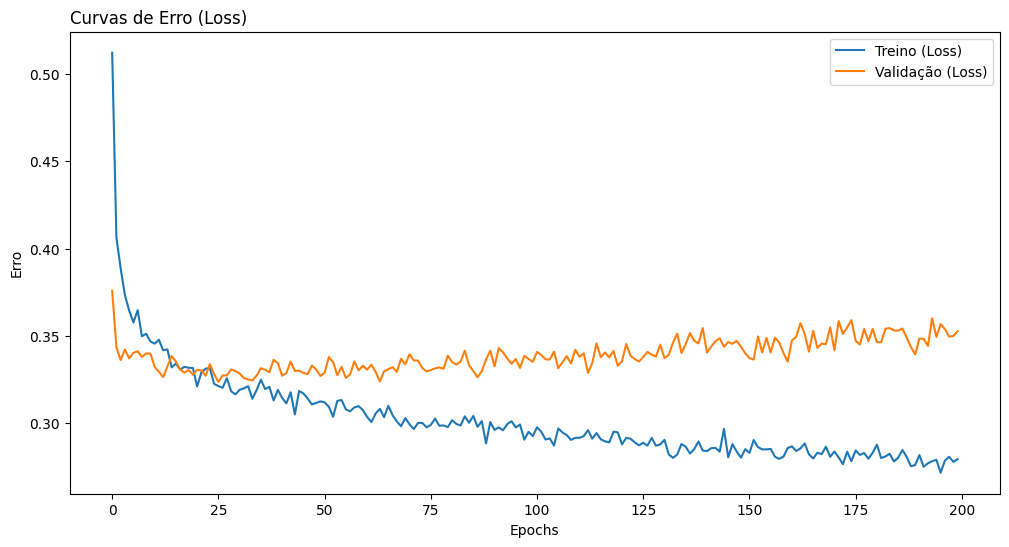

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=history_v4.history, y="loss", x=range(len(history_v4.history["loss"])), label='Train (Loss)')
sns.lineplot(data=history_v4.history, y="val_loss", x=range(len(history_v4.history["val_loss"])), label='Validation (Loss)')
plt.title('Error Curve (Loss)', loc="left")
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show();

In [ ]:
end_time = datetime.now()
delta = end_time - start_time
print(delta)